In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import time
import mani_skill.env
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from torch.distributions import Normal

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

#####################  hyper parameters  ####################

MAX_EPISODES = 3000               # 最大训练代数
MAX_EP_STEPS = 35               # episode最大持续帧数

RENDER = False

LOAD_MEM = False
LOAD_MODEL = False
LOAD_FOLDER_NAME = 'carbinet_pre_FullLoad_1000epi'

LOAD_PRETRAIN = False


ENV_NAME = 'OpenCabinetDrawer-v0'         # 游戏名称
SEED = 123                       # 随机数种子

var = 5
var_low_bound = 0.05

In [6]:
###############################  DDPG  ####################################
class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound,hidden_dim):
        self.a_dim = a_dim
        self.s_dim = s_dim
        self.a_bound = a_bound
        self.hidden_dim = hidden_dim
        self.pointer = 0                                                                         # exp buffer指针
        self.lr_a = 0.001                                                                        # learning rate for actor
        self.lr_c = 0.001                                                                        # learning rate for critic
        self.gamma = 0.9                                                                         # reward discount
        self.tau = 0.001                                                                          # 软更新比例
        self.memory_capacity = 10000
        self.batch_size = 32
        self.memory = np.zeros((self.memory_capacity, s_dim * 2 + a_dim + 1), dtype=np.float32)

        self.Reward_record = []
        
        class ANet(nn.Module):                               # 定义动作网络
            def __init__(self, s_dim, a_dim, a_bound,hidden_size):
                super(ANet,self).__init__()
                self.a_bound = a_bound
                
                self.linear1 = nn.Linear(s_dim, hidden_size)
                self.linear2 = nn.Linear(hidden_size, hidden_size)
                self.linear3 = nn.Linear(hidden_size, a_dim)
                
                self.linear3.weight.data.uniform_(-0.03, 0.03)
                self.linear3.bias.data.uniform_(-0.03, 0.03)
#                 self.fc1 = nn.Linear(s_dim,256)
#                 self.fc1.weight.data.normal_(0,0.1)          # initialization
                
#                 self.fc2 = nn.Linear(256,512)
#                 self.fc2.weight.data.normal_(0,0.1)
#                                
#                 self.fc3 = nn.Linear(512,256)
#                 self.fc3.weight.data.normal_(0,0.1)
                
#                 self.out = nn.Linear(256,a_dim)
#                 self.out.weight.data.normal_(0,0.1)          # initialization
            def forward(self,x):
                x = F.relu(self.linear1(x))
                x = F.relu(self.linear2(x))
                x = F.tanh(self.linear3(x))
                
#                 x = self.fc1(x)
#                 x = F.relu(x)
#                  
#                 x = self.fc2(x)
#                 x = F.relu(x)
                
#                 x = self.fc3(x)
#                 x = F.relu(x)
                
#                 x = self.out(x)
#                 x = F.tanh(x)
                actions_value = x * a_bound
                return actions_value

        class CNet(nn.Module):                               # 定义价值网络
            def __init__(self,s_dim,a_dim,hidden_size):
                super(CNet,self).__init__()
                
                self.linear1 = nn.Linear(s_dim + a_dim, hidden_size)
                self.linear2 = nn.Linear(hidden_size, hidden_size)
                self.linear3 = nn.Linear(hidden_size, 1)

                self.linear3.weight.data.uniform_(-0.03,0.03)
                self.linear3.bias.data.uniform_(-0.03,0.03)

#                 self.fcs1 = nn.Linear(s_dim,256)
#                 self.fcs1.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fcs2 = nn.Linear(256,512)
#                 self.fcs2.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fcs3 = nn.Linear(512,256)
#                 self.fcs3.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01) 
                
#                 self.fca1 = nn.Linear(a_dim,256)
#                 self.fca1.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fca2 = nn.Linear(256,512)
#                 self.fca2.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)              
                
#                 self.fca3 = nn.Linear(512,256)
#                 self.fca3.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.out = nn.Linear(256,1)
#                 self.out.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
            def forward(self,s,a):
        
                x = torch.cat([s, a], 1)
                x = F.relu(self.linear1(x))
                x = F.relu(self.linear2(x))
                x = self.linear3(x)

#                 x = self.fcs1(s)                              # 输入状态
#                 x = F.relu(x)
                
#                 x = self.fcs2(x)
#                 x = F.relu(x)
                
#                 x = self.fcs3(x)
#                 x = F.relu(x) 
                
#                 y = self.fca1(a)                              # 输入动作
#                 y = F.relu(y)
                
#                 y = self.fca2(y)                              
#                 y = F.relu(y)
                
#                 y = self.fca3(y)                              
#                 y = F.relu(y)
                
#                 net = F.relu(x+y)
#                 actions_value = self.out(net)                # 给出V(s,a)
                return x

        self.Actor_eval = ANet(s_dim, a_dim, a_bound, hidden_dim)        # 主网络
        self.Actor_target = ANet(s_dim, a_dim, a_bound, hidden_dim)      # 目标网络
        self.Critic_eval = CNet(s_dim, a_dim,hidden_dim)                # 主网络
        self.Critic_target = CNet(s_dim, a_dim,hidden_dim)              # 当前网络
        self.ctrain = torch.optim.Adam(self.Critic_eval.parameters(),lr = self.lr_c) # critic的优化器
        self.atrain = torch.optim.Adam(self.Actor_eval.parameters(),lr = self.lr_a)  # actor的优化器
        self.loss_td = nn.MSELoss()                          # 损失函数采用均方误差

    def choose_action(self, s):
        s = torch.unsqueeze(torch.FloatTensor(s), 0)
        #print('choose action: ',self.Actor_eval(s))
        #print('choose action 0 : ', self.Actor_eval(s)[0])
        #print('forward: ',self.Actor_eval.forward(s))
        return self.Actor_eval(s)[0].detach()                # detach()不需要计算梯度 #用forward等价（应该

    def learn(self):

        for x in self.Actor_target.state_dict().keys():#更新target network
            eval('self.Actor_target.' + x + '.data.mul_((1 - self.tau))')  
            eval('self.Actor_target.' + x + '.data.add_(self.tau * self.Actor_eval.' + x + '.data)')
        for x in self.Critic_target.state_dict().keys():
            eval('self.Critic_target.' + x + '.data.mul_((1- self.tau))')
            eval('self.Critic_target.' + x + '.data.add_(self.tau * self.Critic_eval.' + x + '.data)')

        # soft target replacement

        indices = np.random.choice(self.memory_capacity, size = self.batch_size)  # 随机采样的index
        bt = self.memory[indices, :]                                              # 采样batch_size个sample
        bs = torch.FloatTensor(bt[:, :self.s_dim])                                # state
        ba = torch.FloatTensor(bt[:, self.s_dim: self.s_dim + self.a_dim])        # action
        br = torch.FloatTensor(bt[:, -self.s_dim - 1: -self.s_dim])               # reward
        bs_ = torch.FloatTensor(bt[:, -self.s_dim:])                              # next state
        
        
        a = self.Actor_eval(bs)
        q = self.Critic_eval(bs,a)  # loss=-q=-ce(s,ae(s))更新ae   ae(s)=a   ae(s_)=a_
        # 如果 a是一个正确的行为的话，那么它的Q应该更贴近0
        loss_a = -torch.mean(q)            #一个batch输入进qu，有好多个q所以要做平均
        #print('q: ',q)
        #print('loss_a: ',loss_a)
        self.atrain.zero_grad()
        loss_a.backward()
        self.atrain.step()
        
        
        a_ = self.Actor_target(bs_)      # 这个网络不及时更新参数, 用于预测 Critic 的 Q_target 中的 action
        q_ = self.Critic_target(bs_,a_)  # 这个网络不及时更新参数, 用于给出 Actor 更新参数时的 Gradient ascent 强度
        q_target = br + self.gamma * q_  # q_target = 负的
        #print('q_target: ', q_target)
        #print('Reward: ', br)
        #print('q_: ', q_)
        q_v = self.Critic_eval(bs,ba)
        #print('q_v: ', q_v)
        td_error = self.loss_td(q_target,q_v)
        # td_error = R + self.gamma * ct（bs_,at(bs_)）-ce(s,ba) 更新ce ,但这个ae(s)是记忆中的ba，让ce得出的Q靠近Q_target,让评价更准确
        # print('td error: ', torch.mean(td_error))
        self.ctrain.zero_grad()
        td_error.backward()
        self.ctrain.step()
        
        
    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % self.memory_capacity     # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1                               # 指示sample位置的指针+1
    
    def store_reward(self,ep_reward):
        self.Reward_record.append(ep_reward)
        
    def save(self,folder_name):
    
        os.mkdir('./DPG model/' + folder_name)
    
        PATH1 = './DPG model/' + folder_name + '/Actor_eval.h5f'
        PATH2 = './DPG model/' + folder_name + '/Actor_target.h5f'
        PATH3 = './DPG model/' + folder_name + '/Critic_eval.h5f'
        PATH4 = './DPG model/' + folder_name + '/Critic_target.h5f'
    
        torch.save(self.Actor_eval.state_dict(), PATH1)
        torch.save(self.Actor_target.state_dict(), PATH2)
        torch.save(self.Critic_eval.state_dict(), PATH3)
        torch.save(self.Critic_target.state_dict(), PATH4)
    
        csv_name='./DPG model/' + folder_name + '/memory.csv'
        xml_df = pd.DataFrame(self.memory)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        csv_name='./DPG model/' + folder_name + '/Rewards.csv'
        xml_df = pd.DataFrame(self.Reward_record)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        y = self.Reward_record
        x = range(len(y))
        plt.figure(figsize=(10, 10), dpi=70)
        plt.scatter(x, y)
        plt.savefig('./DPG model/' + folder_name + '/scatter.png')
        plt.plot(x, y)
        plt.savefig('./DPG model/' + folder_name + '/plot.png')
        
    def plot_file_rewards(self, folder_name):
        data = pd.read_csv('./DPG model/' + folder_name + '/Rewards.csv')
        y = np.array(data).squeeze()
        x = range(y.shape[0])
        plt.figure(figsize=(10, 10), dpi=70)
        #plt.plot(x, y)
        plt.scatter(x, y)
        plt.show()
    
    def plot_rewards(self, scatter):
        y = self.Reward_record
        x = range(len(y))
        plt.figure(figsize=(10, 10), dpi=70)
        
        if scatter:
            plt.scatter(x, y)
        else:
            plt.plot(x, y)
        plt.show()
    
    def load_model(self):
        self.Actor_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_eval.h5f'))
        self.Actor_eval.eval()
        self.Actor_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_target.h5f'))
        self.Actor_target.eval()
        self.Critic_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_eval.h5f'))
        self.Critic_eval.eval()
        self.Critic_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_target.h5f'))
        self.Critic_target.eval()
        print("Load network parameters of: " + LOAD_FOLDER_NAME) 
        
    def load_memory(self):
        data = pd.read_csv('./DPG model/' + LOAD_FOLDER_NAME + '/memory.csv')
        self.memory = np.array(data)
        print("Load memory of: " + LOAD_FOLDER_NAME)
        
    def load_pretrain(self):    
        ddpg.Actor_eval.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
        ddpg.Actor_eval.eval()
        ddpg.Actor_target.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
        ddpg.Actor_target.eval() 
        ddpg.Critic_eval.load_state_dict(torch.load('./DPG model/pretrain/Critic_eval.h5f'))
        ddpg.Critic_eval.eval()
        ddpg.Critic_target.load_state_dict(torch.load('./DPG model/pretrain/Critic_eval.h5f'))
        ddpg.Critic_target.eval()   

In [7]:
###############################  training  ####################################
env = gym.make(ENV_NAME)
env = env.unwrapped
env.seed(SEED)                                          # 设置Gym的随机数种子
torch.manual_seed(SEED)                                 # 设置pytorch的随机数种子

env.set_env_mode(obs_mode='state', reward_type='dense')

s_dim = env.observation_space.shape[0]                  # 状态空间
a_dim = env.action_space.shape[0]                       # 动作空间
a_bound = 1                                             # 动作取值区间,对称区间，故只取上界
hidden_dim = 256
ddpg = DDPG(a_dim, s_dim, a_bound, hidden_dim)

if LOAD_MODEL:
    ddpg.load_model()

    
if LOAD_MEM:
    ddpg.load_memory()

if LOAD_PRETRAIN:
    ddpg.load_pretrain()


if LOAD_MODEL or LOAD_MEM:
    var = 0.1

if LOAD_PRETRAIN:
    var = 0.2

    
t1 = time.time()                                        # 开始时间

for i in range(MAX_EPISODES):
    s = env.reset(level = 1)
    ep_reward = 0

    for j in range(MAX_EP_STEPS):
        if RENDER:
            env.render('human')

        # Add exploration noise
        a = ddpg.choose_action(s)

        a = np.clip(np.random.normal(a, var), -1, 1)    # add randomness to action selection for exploration

        s_, r, done, info = env.step(a)
        
        info_ = info.get('eval_info')
        
        if info_.get('success'):
            print('SUCCESS')
            r += 100 #+200
        
        r += 10
        r = r * 200
        r+= 200
        #print(r)
        ddpg.store_transition(s, a, r, s_)         # 为什么要对reward归一化
    
        
        if ddpg.pointer > ddpg.memory_capacity or LOAD_MEM:         # 经验池已满
            if var > var_low_bound:
                var *= .9995                            # 学习阶段逐渐降低动作随机性decay the action randomness
            ddpg.learn()                                # 开始学习

        s = s_
        ep_reward += r
        if j == MAX_EP_STEPS -1 or done:
            print('Episode:', i, ' Reward: %i' % int(ep_reward/j), 'Explore: %.2f' % var, )
            
            ddpg.store_reward(ep_reward/j)
            
            #if ddpg.pointer > ddpg.memory_capacity and done:
                #RENDER = True
            
            break
               
print('Running time: ', time.time() - t1)

/home/fyf0702/miniconda3/envs/mani_skill/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 0  Reward: -346 Explore: 5.00
Episode: 1  Reward: -236 Explore: 5.00
Episode: 2  Reward: -705 Explore: 5.00
Episode: 3  Reward: -457 Explore: 5.00
Episode: 4  Reward: -382 Explore: 5.00
Episode: 5  Reward: -393 Explore: 5.00
Episode: 6  Reward: -446 Explore: 5.00
Episode: 7  Reward: -258 Explore: 5.00
Episode: 8  Reward: -528 Explore: 5.00
Episode: 9  Reward: -500 Explore: 5.00
Episode: 10  Reward: -180 Explore: 5.00
Episode: 11  Reward: -352 Explore: 5.00
Episode: 12  Reward: -536 Explore: 5.00
Episode: 13  Reward: -824 Explore: 5.00
Episode: 14  Reward: -229 Explore: 5.00
Episode: 15  Reward: -252 Explore: 5.00
Episode: 16  Reward: -496 Explore: 5.00
Episode: 17  Reward: -364 Explore: 5.00
Episode: 18  Reward: -299 Explore: 5.00
Episode: 19  Reward: -302 Explore: 5.00
Episode: 20  Reward: -338 Explore: 5.00
Episode: 21  Reward: -419 Explore: 5.00
Episode: 22  Reward: -414 Explore: 5.00
Episode: 23  Reward: -213 Explore: 5.00
Episode: 24  Reward: -281 Explore: 5.00
Episode: 2

Episode: 203  Reward: -313 Explore: 5.00
Episode: 204  Reward: -299 Explore: 5.00
Episode: 205  Reward: -384 Explore: 5.00
Episode: 206  Reward: -291 Explore: 5.00
Episode: 207  Reward: -305 Explore: 5.00
Episode: 208  Reward: -214 Explore: 5.00
Episode: 209  Reward: -329 Explore: 5.00
Episode: 210  Reward: -597 Explore: 5.00
Episode: 211  Reward: -188 Explore: 5.00
Episode: 212  Reward: -287 Explore: 5.00
Episode: 213  Reward: -620 Explore: 5.00
Episode: 214  Reward: -283 Explore: 5.00
Episode: 215  Reward: -167 Explore: 5.00
Episode: 216  Reward: -629 Explore: 5.00
Episode: 217  Reward: -525 Explore: 5.00
Episode: 218  Reward: -604 Explore: 5.00
Episode: 219  Reward: -315 Explore: 5.00
Episode: 220  Reward: -528 Explore: 5.00
Episode: 221  Reward: -339 Explore: 5.00
Episode: 222  Reward: -294 Explore: 5.00
Episode: 223  Reward: -432 Explore: 5.00
Episode: 224  Reward: -461 Explore: 5.00
Episode: 225  Reward: -217 Explore: 5.00
Episode: 226  Reward: -806 Explore: 5.00
Episode: 227  Re

Episode: 405  Reward: 56 Explore: 0.61
Episode: 406  Reward: 103 Explore: 0.60
Episode: 407  Reward: 55 Explore: 0.59
Episode: 408  Reward: 82 Explore: 0.58
Episode: 409  Reward: 56 Explore: 0.57
Episode: 410  Reward: 79 Explore: 0.56
Episode: 411  Reward: -17 Explore: 0.55
Episode: 412  Reward: 104 Explore: 0.54
Episode: 413  Reward: -19 Explore: 0.53
Episode: 414  Reward: -44 Explore: 0.52
Episode: 415  Reward: 84 Explore: 0.51
Episode: 416  Reward: 54 Explore: 0.50
Episode: 417  Reward: 36 Explore: 0.49
Episode: 418  Reward: 56 Explore: 0.48
Episode: 419  Reward: 65 Explore: 0.48
Episode: 420  Reward: 44 Explore: 0.47
Episode: 421  Reward: 78 Explore: 0.46
Episode: 422  Reward: 61 Explore: 0.45
Episode: 423  Reward: 74 Explore: 0.44
Episode: 424  Reward: 0 Explore: 0.44
Episode: 425  Reward: 60 Explore: 0.43
Episode: 426  Reward: 69 Explore: 0.42
Episode: 427  Reward: 40 Explore: 0.41
Episode: 428  Reward: 16 Explore: 0.41
Episode: 429  Reward: 98 Explore: 0.40
Episode: 430  Reward:

Episode: 614  Reward: 147 Explore: 0.05
Episode: 615  Reward: 89 Explore: 0.05
Episode: 616  Reward: 65 Explore: 0.05
Episode: 617  Reward: 138 Explore: 0.05
Episode: 618  Reward: 115 Explore: 0.05
Episode: 619  Reward: 123 Explore: 0.05
Episode: 620  Reward: 137 Explore: 0.05
Episode: 621  Reward: 136 Explore: 0.05
Episode: 622  Reward: 121 Explore: 0.05
Episode: 623  Reward: 98 Explore: 0.05
Episode: 624  Reward: 114 Explore: 0.05
Episode: 625  Reward: 137 Explore: 0.05
Episode: 626  Reward: 126 Explore: 0.05
Episode: 627  Reward: 130 Explore: 0.05
Episode: 628  Reward: 121 Explore: 0.05
Episode: 629  Reward: 129 Explore: 0.05
Episode: 630  Reward: 141 Explore: 0.05
Episode: 631  Reward: 137 Explore: 0.05
Episode: 632  Reward: 131 Explore: 0.05
Episode: 633  Reward: 118 Explore: 0.05
Episode: 634  Reward: 118 Explore: 0.05
Episode: 635  Reward: 148 Explore: 0.05
Episode: 636  Reward: 119 Explore: 0.05
Episode: 637  Reward: 112 Explore: 0.05
Episode: 638  Reward: 130 Explore: 0.05
Epi

Episode: 820  Reward: 139 Explore: 0.05
Episode: 821  Reward: 150 Explore: 0.05
Episode: 822  Reward: 147 Explore: 0.05
Episode: 823  Reward: 149 Explore: 0.05
Episode: 824  Reward: 136 Explore: 0.05
Episode: 825  Reward: 232 Explore: 0.05
Episode: 826  Reward: 153 Explore: 0.05
Episode: 827  Reward: 149 Explore: 0.05
Episode: 828  Reward: 141 Explore: 0.05
Episode: 829  Reward: 243 Explore: 0.05
Episode: 830  Reward: 214 Explore: 0.05
Episode: 831  Reward: 158 Explore: 0.05
Episode: 832  Reward: 130 Explore: 0.05
Episode: 833  Reward: 154 Explore: 0.05
Episode: 834  Reward: 132 Explore: 0.05
Episode: 835  Reward: 186 Explore: 0.05
Episode: 836  Reward: 123 Explore: 0.05
Episode: 837  Reward: 132 Explore: 0.05
Episode: 838  Reward: 158 Explore: 0.05
Episode: 839  Reward: 143 Explore: 0.05
Episode: 840  Reward: 209 Explore: 0.05
Episode: 841  Reward: 132 Explore: 0.05
Episode: 842  Reward: 134 Explore: 0.05
Episode: 843  Reward: 253 Explore: 0.05
Episode: 844  Reward: 141 Explore: 0.05


Episode: 1025  Reward: 244 Explore: 0.05
Episode: 1026  Reward: 209 Explore: 0.05
Episode: 1027  Reward: 151 Explore: 0.05
Episode: 1028  Reward: 158 Explore: 0.05
Episode: 1029  Reward: 200 Explore: 0.05
Episode: 1030  Reward: 146 Explore: 0.05
Episode: 1031  Reward: 251 Explore: 0.05
Episode: 1032  Reward: 147 Explore: 0.05
Episode: 1033  Reward: 165 Explore: 0.05
Episode: 1034  Reward: 244 Explore: 0.05
Episode: 1035  Reward: 171 Explore: 0.05
Episode: 1036  Reward: 131 Explore: 0.05
Episode: 1037  Reward: 144 Explore: 0.05
Episode: 1038  Reward: 203 Explore: 0.05
Episode: 1039  Reward: 291 Explore: 0.05
Episode: 1040  Reward: 144 Explore: 0.05
Episode: 1041  Reward: 201 Explore: 0.05
Episode: 1042  Reward: 140 Explore: 0.05
Episode: 1043  Reward: 168 Explore: 0.05
Episode: 1044  Reward: 259 Explore: 0.05
Episode: 1045  Reward: 125 Explore: 0.05
Episode: 1046  Reward: 141 Explore: 0.05
Episode: 1047  Reward: 130 Explore: 0.05
Episode: 1048  Reward: 216 Explore: 0.05
Episode: 1049  R

Episode: 1225  Reward: 253 Explore: 0.05
Episode: 1226  Reward: 275 Explore: 0.05
Episode: 1227  Reward: 153 Explore: 0.05
Episode: 1228  Reward: 178 Explore: 0.05
Episode: 1229  Reward: 285 Explore: 0.05
Episode: 1230  Reward: 149 Explore: 0.05
Episode: 1231  Reward: 196 Explore: 0.05
Episode: 1232  Reward: 143 Explore: 0.05
Episode: 1233  Reward: 148 Explore: 0.05
Episode: 1234  Reward: 274 Explore: 0.05
Episode: 1235  Reward: 142 Explore: 0.05
Episode: 1236  Reward: 147 Explore: 0.05
Episode: 1237  Reward: 146 Explore: 0.05
Episode: 1238  Reward: 140 Explore: 0.05
Episode: 1239  Reward: 207 Explore: 0.05
Episode: 1240  Reward: 254 Explore: 0.05
Episode: 1241  Reward: 93 Explore: 0.05
Episode: 1242  Reward: 202 Explore: 0.05
Episode: 1243  Reward: 287 Explore: 0.05
Episode: 1244  Reward: 137 Explore: 0.05
Episode: 1245  Reward: 188 Explore: 0.05
Episode: 1246  Reward: 288 Explore: 0.05
Episode: 1247  Reward: 272 Explore: 0.05
Episode: 1248  Reward: 225 Explore: 0.05
Episode: 1249  Re

Episode: 1425  Reward: 233 Explore: 0.05
Episode: 1426  Reward: 164 Explore: 0.05
Episode: 1427  Reward: 260 Explore: 0.05
Episode: 1428  Reward: 327 Explore: 0.05
Episode: 1429  Reward: 328 Explore: 0.05
Episode: 1430  Reward: 300 Explore: 0.05
Episode: 1431  Reward: 324 Explore: 0.05
Episode: 1432  Reward: 275 Explore: 0.05
Episode: 1433  Reward: 293 Explore: 0.05
Episode: 1434  Reward: 303 Explore: 0.05
Episode: 1435  Reward: 333 Explore: 0.05
Episode: 1436  Reward: 263 Explore: 0.05
Episode: 1437  Reward: 218 Explore: 0.05
Episode: 1438  Reward: 288 Explore: 0.05
Episode: 1439  Reward: 163 Explore: 0.05
Episode: 1440  Reward: 286 Explore: 0.05
Episode: 1441  Reward: 307 Explore: 0.05
Episode: 1442  Reward: 300 Explore: 0.05
Episode: 1443  Reward: 289 Explore: 0.05
Episode: 1444  Reward: 295 Explore: 0.05
Episode: 1445  Reward: 281 Explore: 0.05
Episode: 1446  Reward: 155 Explore: 0.05
Episode: 1447  Reward: 311 Explore: 0.05
Episode: 1448  Reward: 141 Explore: 0.05
Episode: 1449  R

Episode: 1625  Reward: 149 Explore: 0.05
Episode: 1626  Reward: 290 Explore: 0.05
Episode: 1627  Reward: 96 Explore: 0.05
Episode: 1628  Reward: 116 Explore: 0.05
Episode: 1629  Reward: 39 Explore: 0.05
Episode: 1630  Reward: 128 Explore: 0.05
Episode: 1631  Reward: 129 Explore: 0.05
Episode: 1632  Reward: 168 Explore: 0.05
Episode: 1633  Reward: 139 Explore: 0.05
Episode: 1634  Reward: 269 Explore: 0.05
Episode: 1635  Reward: 269 Explore: 0.05
Episode: 1636  Reward: 314 Explore: 0.05
Episode: 1637  Reward: 149 Explore: 0.05
Episode: 1638  Reward: 140 Explore: 0.05
Episode: 1639  Reward: 124 Explore: 0.05
Episode: 1640  Reward: 110 Explore: 0.05
Episode: 1641  Reward: 123 Explore: 0.05
Episode: 1642  Reward: 71 Explore: 0.05
Episode: 1643  Reward: 115 Explore: 0.05
Episode: 1644  Reward: 120 Explore: 0.05
Episode: 1645  Reward: 138 Explore: 0.05
Episode: 1646  Reward: 246 Explore: 0.05
Episode: 1647  Reward: 130 Explore: 0.05
Episode: 1648  Reward: 79 Explore: 0.05
Episode: 1649  Rewar

Episode: 1826  Reward: 345 Explore: 0.05
Episode: 1827  Reward: 306 Explore: 0.05
Episode: 1828  Reward: 219 Explore: 0.05
Episode: 1829  Reward: 255 Explore: 0.05
Episode: 1830  Reward: 274 Explore: 0.05
Episode: 1831  Reward: 305 Explore: 0.05
Episode: 1832  Reward: 318 Explore: 0.05
Episode: 1833  Reward: 362 Explore: 0.05
Episode: 1834  Reward: 255 Explore: 0.05
Episode: 1835  Reward: 133 Explore: 0.05
Episode: 1836  Reward: 257 Explore: 0.05
Episode: 1837  Reward: 232 Explore: 0.05
Episode: 1838  Reward: 293 Explore: 0.05
Episode: 1839  Reward: 342 Explore: 0.05
Episode: 1840  Reward: 280 Explore: 0.05
Episode: 1841  Reward: 163 Explore: 0.05
Episode: 1842  Reward: 290 Explore: 0.05
Episode: 1843  Reward: 295 Explore: 0.05
Episode: 1844  Reward: 283 Explore: 0.05
Episode: 1845  Reward: 128 Explore: 0.05
Episode: 1846  Reward: 148 Explore: 0.05
Episode: 1847  Reward: 327 Explore: 0.05
Episode: 1848  Reward: 215 Explore: 0.05
Episode: 1849  Reward: 351 Explore: 0.05
Episode: 1850  R

Episode: 2026  Reward: 304 Explore: 0.05
Episode: 2027  Reward: 314 Explore: 0.05
Episode: 2028  Reward: 356 Explore: 0.05
Episode: 2029  Reward: 311 Explore: 0.05
Episode: 2030  Reward: 135 Explore: 0.05
Episode: 2031  Reward: 341 Explore: 0.05
Episode: 2032  Reward: 309 Explore: 0.05
Episode: 2033  Reward: 335 Explore: 0.05
Episode: 2034  Reward: 328 Explore: 0.05
Episode: 2035  Reward: 325 Explore: 0.05
Episode: 2036  Reward: 347 Explore: 0.05
Episode: 2037  Reward: 300 Explore: 0.05
Episode: 2038  Reward: 117 Explore: 0.05
Episode: 2039  Reward: 363 Explore: 0.05
Episode: 2040  Reward: 333 Explore: 0.05
Episode: 2041  Reward: 337 Explore: 0.05
Episode: 2042  Reward: 297 Explore: 0.05
Episode: 2043  Reward: 297 Explore: 0.05
Episode: 2044  Reward: 257 Explore: 0.05
Episode: 2045  Reward: 368 Explore: 0.05
Episode: 2046  Reward: 130 Explore: 0.05
Episode: 2047  Reward: 344 Explore: 0.05
Episode: 2048  Reward: 275 Explore: 0.05
Episode: 2049  Reward: 336 Explore: 0.05
Episode: 2050  R

Episode: 2226  Reward: 318 Explore: 0.05
Episode: 2227  Reward: 331 Explore: 0.05
Episode: 2228  Reward: 234 Explore: 0.05
Episode: 2229  Reward: 354 Explore: 0.05
Episode: 2230  Reward: 389 Explore: 0.05
Episode: 2231  Reward: 369 Explore: 0.05
Episode: 2232  Reward: 365 Explore: 0.05
Episode: 2233  Reward: 360 Explore: 0.05
Episode: 2234  Reward: 146 Explore: 0.05
Episode: 2235  Reward: 361 Explore: 0.05
Episode: 2236  Reward: 202 Explore: 0.05
Episode: 2237  Reward: 270 Explore: 0.05
Episode: 2238  Reward: 377 Explore: 0.05
Episode: 2239  Reward: 361 Explore: 0.05
Episode: 2240  Reward: 243 Explore: 0.05
Episode: 2241  Reward: 213 Explore: 0.05
Episode: 2242  Reward: 172 Explore: 0.05
Episode: 2243  Reward: 353 Explore: 0.05
Episode: 2244  Reward: 90 Explore: 0.05
Episode: 2245  Reward: 278 Explore: 0.05
Episode: 2246  Reward: 376 Explore: 0.05
Episode: 2247  Reward: 340 Explore: 0.05
Episode: 2248  Reward: 304 Explore: 0.05
Episode: 2249  Reward: 280 Explore: 0.05
Episode: 2250  Re

Episode: 2426  Reward: 364 Explore: 0.05
Episode: 2427  Reward: 362 Explore: 0.05
Episode: 2428  Reward: 313 Explore: 0.05
Episode: 2429  Reward: 335 Explore: 0.05
Episode: 2430  Reward: 349 Explore: 0.05
Episode: 2431  Reward: 378 Explore: 0.05
Episode: 2432  Reward: 379 Explore: 0.05
Episode: 2433  Reward: 372 Explore: 0.05
Episode: 2434  Reward: 385 Explore: 0.05
Episode: 2435  Reward: 385 Explore: 0.05
Episode: 2436  Reward: 375 Explore: 0.05
Episode: 2437  Reward: 343 Explore: 0.05
Episode: 2438  Reward: 375 Explore: 0.05
Episode: 2439  Reward: 358 Explore: 0.05
Episode: 2440  Reward: 368 Explore: 0.05
Episode: 2441  Reward: 371 Explore: 0.05
Episode: 2442  Reward: 353 Explore: 0.05
Episode: 2443  Reward: 302 Explore: 0.05
Episode: 2444  Reward: 376 Explore: 0.05
Episode: 2445  Reward: 137 Explore: 0.05
Episode: 2446  Reward: 362 Explore: 0.05
Episode: 2447  Reward: 364 Explore: 0.05
Episode: 2448  Reward: 351 Explore: 0.05
Episode: 2449  Reward: 359 Explore: 0.05
Episode: 2450  R

Episode: 2626  Reward: 325 Explore: 0.05
Episode: 2627  Reward: 303 Explore: 0.05
Episode: 2628  Reward: 231 Explore: 0.05
Episode: 2629  Reward: 184 Explore: 0.05
Episode: 2630  Reward: 299 Explore: 0.05
Episode: 2631  Reward: 307 Explore: 0.05
Episode: 2632  Reward: 297 Explore: 0.05
Episode: 2633  Reward: 318 Explore: 0.05
Episode: 2634  Reward: 313 Explore: 0.05
Episode: 2635  Reward: 275 Explore: 0.05
Episode: 2636  Reward: 305 Explore: 0.05
Episode: 2637  Reward: 310 Explore: 0.05
Episode: 2638  Reward: 131 Explore: 0.05
Episode: 2639  Reward: 288 Explore: 0.05
Episode: 2640  Reward: 370 Explore: 0.05
Episode: 2641  Reward: 262 Explore: 0.05
Episode: 2642  Reward: 346 Explore: 0.05
Episode: 2643  Reward: 309 Explore: 0.05
Episode: 2644  Reward: 239 Explore: 0.05
Episode: 2645  Reward: 312 Explore: 0.05
Episode: 2646  Reward: 142 Explore: 0.05
Episode: 2647  Reward: 250 Explore: 0.05
Episode: 2648  Reward: 110 Explore: 0.05
Episode: 2649  Reward: 305 Explore: 0.05
Episode: 2650  R

Episode: 2827  Reward: 377 Explore: 0.05
Episode: 2828  Reward: 326 Explore: 0.05
Episode: 2829  Reward: 351 Explore: 0.05
Episode: 2830  Reward: 345 Explore: 0.05
Episode: 2831  Reward: 320 Explore: 0.05
Episode: 2832  Reward: 374 Explore: 0.05
Episode: 2833  Reward: 182 Explore: 0.05
Episode: 2834  Reward: 358 Explore: 0.05
Episode: 2835  Reward: 367 Explore: 0.05
Episode: 2836  Reward: 371 Explore: 0.05
Episode: 2837  Reward: 378 Explore: 0.05
Episode: 2838  Reward: 380 Explore: 0.05
Episode: 2839  Reward: 378 Explore: 0.05
Episode: 2840  Reward: 376 Explore: 0.05
Episode: 2841  Reward: 383 Explore: 0.05
Episode: 2842  Reward: 366 Explore: 0.05
Episode: 2843  Reward: 377 Explore: 0.05
Episode: 2844  Reward: 371 Explore: 0.05
Episode: 2845  Reward: 355 Explore: 0.05
Episode: 2846  Reward: 380 Explore: 0.05
Episode: 2847  Reward: 346 Explore: 0.05
Episode: 2848  Reward: 360 Explore: 0.05
Episode: 2849  Reward: 325 Explore: 0.05
Episode: 2850  Reward: 360 Explore: 0.05
Episode: 2851  R

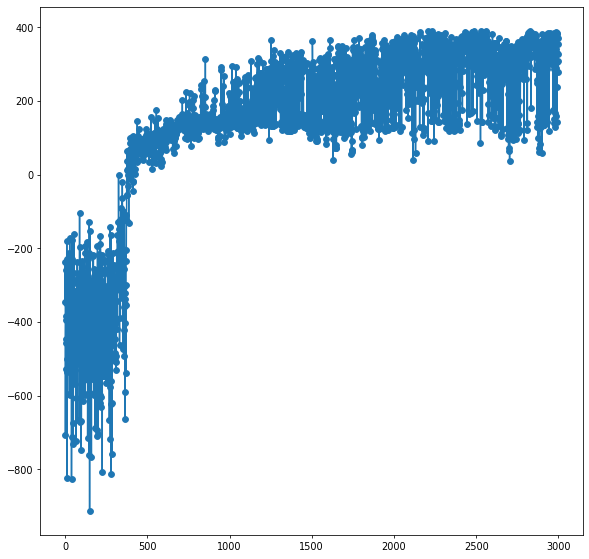

In [8]:
ddpg.save('carbinet_self_learning_3000epi_v0')

In [9]:
done

False

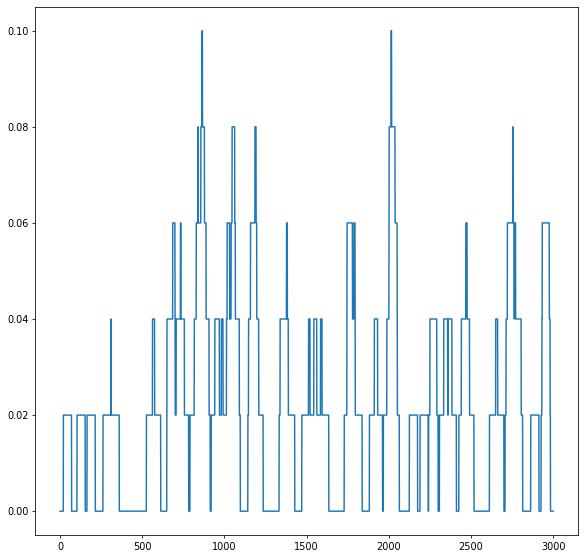

In [10]:
data = pd.read_csv('./DPG model/carbinet_pre-loaded_3000epi/Rewards.csv')
y = np.array(data).squeeze()
x = range(y.shape[0])

z = np.zeros(len(y)+50)
for i in range(len(y)):
    if y[i] >= 10:
        z[i] = 1
        
z_ = np.zeros(len(y))

for i in range(len(z_)):
    for j in range(50):
        z_[i] += z[i+j]
    z_[i] = z_[i] / 50

plt.figure(figsize=(10, 10), dpi=70)
plt.plot(x, z_)
plt.show()

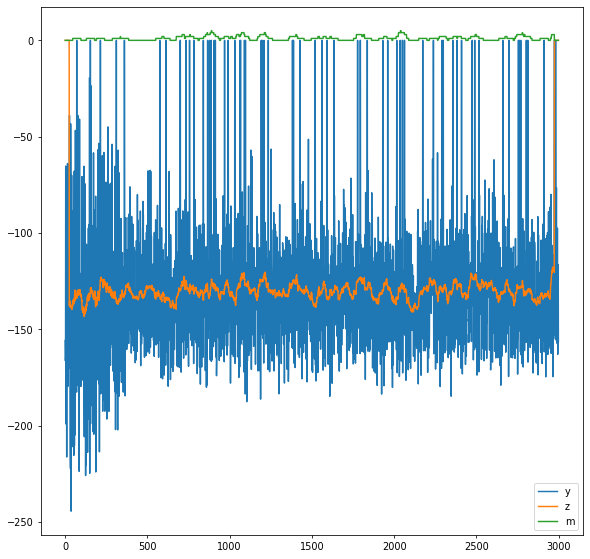

maximum success rate:  0.1
maximum mean rewards:  0.0


In [11]:
data = pd.read_csv('./DPG model/carbinet_pre-loaded_3000epi/Rewards.csv')
y = np.array(data).squeeze()
x = range(y.shape[0])

size = 50

z = np.zeros(len(y))
m = np.zeros(len(y))

for i in range(len(y)):
    if y[i] >= 10:
        y[i] = 0
        
for i in range(len(y)):
    
    if i > (size/2 -1) and i < (len(y) - size/2):  
        for j in range(size):
            z[i] += y[i + j - int(size/2)]  #平均reward
            
            if(y[i + j - int(size/2)] == 0):
                m[i] += 1                  #success rate
            
                                   
            
        z[i] = z[i] / size
        m[i] = m[i]
        

    
    
plt.figure(figsize=(10, 10), dpi=70)

plt.plot(x, y)
plt.plot(x, z)
plt.plot(x, m)

plt.legend(['y','z','m'])
plt.show()

print('maximum success rate: ', max(m)/50)
print('maximum mean rewards: ', max(z))